In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

test['Survived'] = np.nan
main_data = pd.concat([train,test],ignore_index=True,sort=False)

In [3]:
main_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
main_data.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
dtype: int64

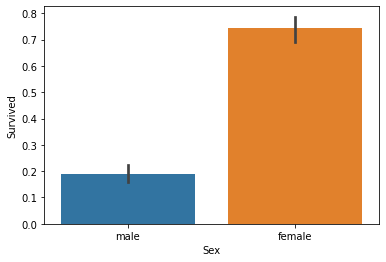

In [5]:
sns.barplot(x='Sex',y='Survived',data=main_data)
plt.show()

In [10]:
#----Predict Age-------------
from sklearn.ensemble import RandomForestRegressor

age_df = main_data[['Age','Pclass','Sex','Parch','SibSp']]
age_df=pd.get_dummies(age_df)

#Separate train and test data and convert to numpy array.
known_age = age_df[age_df.Age.notnull()].values
unknown_age = age_df[age_df.Age.isnull()].values

x = known_age[:,1:]
y = known_age[:,0]

In [11]:
x

array([[3., 0., 1., 0., 1.],
       [1., 0., 1., 1., 0.],
       [3., 0., 0., 1., 0.],
       ...,
       [3., 0., 0., 1., 0.],
       [1., 0., 0., 1., 0.],
       [3., 0., 0., 0., 1.]])